# Packages

In [1]:
using Pkg
using Plots
using Random
using Dates
using DataFrames
using Statistics
using AlphaVantage
using Distributions
using HypothesisTests
using FractionalCalculus
using Downloads
using CSV
using MarketData
using Pandas
using SciPy
sch = SciPy.cluster.hierarchy

PyObject <module 'scipy.cluster.hierarchy' from 'C:\\Users\\RR\\.julia\\conda\\3\\lib\\site-packages\\scipy\\cluster\\hierarchy.py'>

# Include jl file

In [2]:
include("HRP.jl")

hrpMC

# Data

In [4]:
stocks = [:AAPL, :MSFT, :GOOG, :AMZN, :TSLA, :NFLX, :WMT, :F, :AAL, :META]
start = DateTime(2020, 1, 1)
allStocks = []
for symb in stocks
    data = DataFrames.DataFrame(yahoo(symb, YahooOpt(period1 = start)))
    priceAdjClose = data.AdjClose
    if getindex(stocks, 1) == symb
        timeStamp = data.timestamp
        allStocks = hcat(timeStamp, priceAdjClose)
    else
        allStocks = hcat(allStocks, priceAdjClose)
    end
end
allStocksPrices = DataFrames.DataFrame(allStocks, :auto)
allStocksPrices = DataFrames.rename(allStocksPrices, names(allStocksPrices) .=> String.(append!([:Dates], stocks)))
CSV.write("Data_Prices.csv", allStocksPrices)

"Data_Prices.csv"

In [5]:
first(allStocksPrices, 10)

,Dates,AAPL,MSFT,GOOG,AMZN,TSLA,NFLX,WMT,F
,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,2020-01-02,73.7859,156.924,1367.37,94.9005,86.052,329.81,114.297,9.10833
2,2020-01-03,73.0686,154.97,1360.66,93.7485,88.602,325.9,113.288,8.90528
3,2020-01-06,73.6508,155.371,1394.21,95.144,90.308,335.83,113.057,8.85693
4,2020-01-07,73.3044,153.954,1393.34,95.343,93.812,330.75,112.01,8.94395
5,2020-01-08,74.4836,156.407,1404.32,94.5985,98.428,339.26,111.625,8.94395
6,2020-01-09,76.0657,158.361,1419.83,95.0525,96.268,335.66,112.778,8.95362
7,2020-01-10,76.2377,157.628,1429.73,94.158,95.63,329.05,111.837,8.94395
8,2020-01-13,77.8664,159.523,1439.23,94.565,104.972,338.92,111.356,8.93428
9,2020-01-14,76.815,158.4,1430.88,93.472,107.584,338.69,111.644,8.98263


In [6]:
function pctChange(prices::DataFrames.DataFrame)
    returns = DataFrames.DataFrame()
    for sym in names(prices)[2:end]
        x = prices[!, Symbol(sym)]
        ret = Array{Float64}(undef, length(x))
        ret[1] = NaN
        for i ∈ 2:length(x)
            ret[i] = (x[i]/x[i-1]) - 1
        end
        returns[!, Symbol(sym)] = ret
    end
    return returns
end

pctChange (generic function with 1 method)

In [7]:
allStocksReturns = pctChange(allStocksPrices)[1:end, :]
CSV.write("Data_Returns.csv", allStocksReturns)
allStocksReturns[1:10, :]

,AAPL,MSFT,GOOG,AMZN,TSLA,NFLX
,Float64,Float64,Float64,Float64,Float64,Float64
1,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.00972199,-0.0124517,-0.0049072,-0.012139,0.0296332,-0.0118553
3,0.00796784,0.00258484,0.0246571,0.0148856,0.0192547,0.0304694
4,-0.00470283,-0.0091177,-0.000624006,0.00209162,0.0388005,-0.0151267
5,0.0160863,0.0159283,0.00788033,-0.00780864,0.0492048,0.0257294
6,0.0212408,0.0124928,0.0110445,0.00479918,-0.021945,-0.0106113
7,0.00226057,-0.00462705,0.00697268,-0.0094106,-0.00662734,-0.0196926
8,0.0213645,0.0120243,0.00664461,0.00432257,0.097689,0.0299955
9,-0.0135033,-0.00704299,-0.0058017,-0.0115582,0.0248828,-0.000678659


# Snippet 16.1, 16.2

In [8]:
covariance = cov(Matrix(allStocksReturns[2:end, :]))
correlation = cor(Matrix(allStocksReturns[2:end, :]));

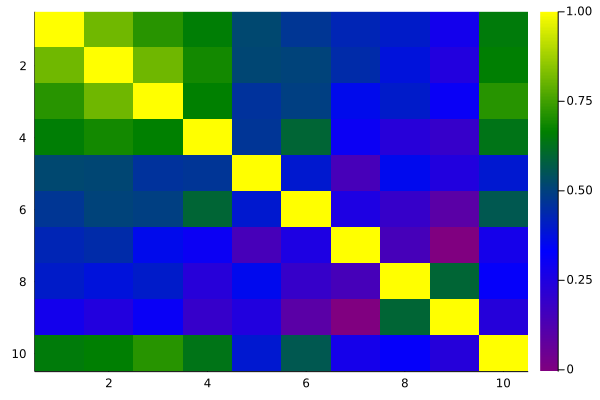

In [9]:
heatmap(correlation, c = cgrad([:purple, :blue, :green, :yellow]), yflip = true)

In [12]:
distance = distanceCorr(correlation)
link = sch.linkage(distance, "single")

sys:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


9×4 Matrix{Float64}:
  0.0   1.0  0.623085   2.0
  2.0  10.0  0.630541   3.0
  9.0  11.0  0.776751   4.0
  3.0  12.0  0.828841   5.0
  7.0   8.0  0.9171     2.0
  5.0  13.0  0.937246   6.0
  4.0  15.0  1.07877    7.0
 14.0  16.0  1.18496    9.0
  6.0  17.0  1.25126   10.0

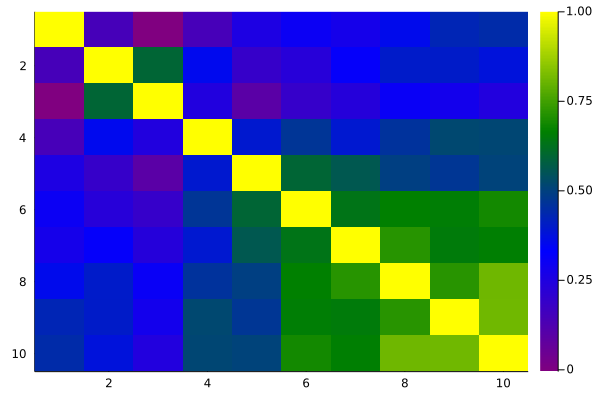

In [13]:
sortIx = quasiDiagonal(link)
correlationSorted = correlation[sortIx .+ 1, sortIx .+ 1]
heatmap(correlationSorted, c = cgrad([:purple, :blue, :green, :yellow]), yflip = true)

# Snippet 16.3

In [14]:
hrp = recursiveBisection(covariance, sortIx)
hrp.name = vec(stocks[transpose(hrp.index.+1)])
hrp

,index,weight,name
,Int64,Float64,Symbol
1,6,0.380423,WMT
2,7,0.0997967,F
3,8,0.0401472,AAL
4,4,0.0324827,TSLA
5,5,0.068875,NFLX
6,3,0.0979995,AMZN
7,9,0.0655324,META
8,2,0.110017,GOOG
9,0,0.0486189,AAPL


# Sum

In [15]:
hrp = HRP(covariance, correlation)
DataFrames.DataFrame(weight = hrp, stocks = stocks)

,weight,stocks
,Float64,Symbol
1,0.0486189,AAPL
2,0.0561082,MSFT
3,0.110017,GOOG
4,0.0979995,AMZN
5,0.0324827,TSLA
6,0.068875,NFLX
7,0.380423,WMT
8,0.0997967,F
9,0.0401472,AAL


# Next part

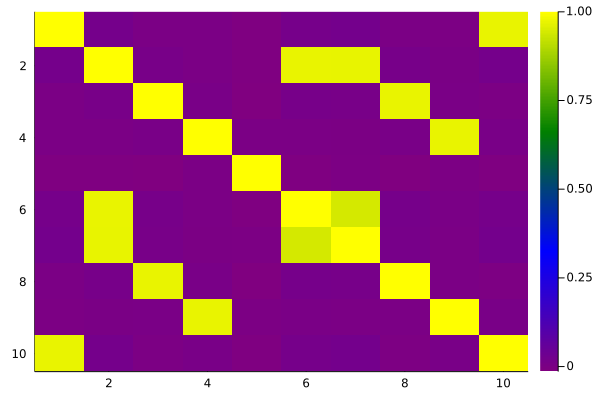

In [20]:
#1) Generate correlated data
numberObs, size0, size1, sigma1 = 10000, 5, 5, .25
data, cols = randomData(numberObs, size0, size1, sigma1)
##cov and corr
cov_ = cov(Matrix(data))
corr_ = cor(Matrix(data))
#2) compute and plot correl matrix
heatmap(corr_, c = cgrad([:purple, :blue, :green, :yellow]), yflip = true)

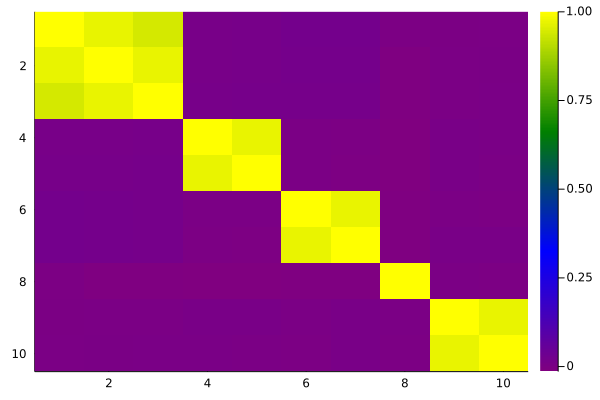

In [23]:
#3) cluster
distance = distanceCorr(corr_)
link = sch.linkage(distance, "single")
sortIx = quasiDiagonal(link)
corrSorted = corr_[sortIx .+ 1, sortIx .+ 1]
heatmap(corrSorted, c = cgrad([:purple, :blue, :green, :yellow]), yflip = true)

In [24]:
#4) Capital allocation
hrp = recursiveBisection(cov_, sortIx)
hrp[:, [end - 1, end]]

,index,weight
,Int64,Float64
1,6,0.0709545
2,1,0.0753235
3,5,0.123922
4,2,0.0676393
5,7,0.0641612
6,0,0.107569
7,9,0.100854
8,4,0.197154
9,3,0.0991717


# Monte Carlo simulation

In [25]:
hrpMC()